<a href="https://colab.research.google.com/github/MichaelGajhede/superdex_75_calibration/blob/main/Kopi_af_superdex_75_calib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simple script to calculate the molecular weigth from a SEC elution volume


## Why is log(MW) Linear with Kav in SEC?

In size exclusion chromatography (SEC), we often observe a linear relationship between the logarithm of the molecular weight (log(MW)) of a molecule and its distribution coefficient, Kav.  Here's why:

### 1. SEC Separation

SEC separates molecules based on their size in solution, quantified as hydrodynamic volume ($V_h$).

### 2. Hydrodynamic Volume and Molecular Weight

The hydrodynamic volume is related to the molecular weight (MW) by the following relationship:

$\
V_h \propto MW^a
\$

where 'a' is a constant that depends on the polymer or protein conformation in solution (typically between 0.5 and 0.8 for linear polymers).

### 3. Kav and Hydrodynamic Volume

Kav is defined as:

$\
K_{av} = \frac{V_e - V_o}{V_t - V_o}
\$

Where:
- $V_e$ is the elution volume
- $V_o$ is the void volume
- $V_t$ is the total column volume

Kav represents the fraction of the stationary phase's pore volume available to a given molecule.  Molecules with a larger $V_h$ have less access to the pores, resulting in a smaller Kav, and vice versa.  Therefore, Kav is inversely related to $V_h$.

### 4. The Linear Relationship

Combining the relationships:

-  $V_h \propto MW^a$
-  Kav is inversely related to $V_h$

Taking the logarithm of the first equation:
$
log(V_h) = a \cdot log(MW) + constant
$

Since Kav is inversely related to $V_h$,  Kav will also be related to  $log(MW)$.  Empirically, in many SEC systems, this relationship approximates to a linear one:

$\
log(MW) = A \cdot K_{av} + B
\$

Where A and B are constants obtained from the calibration curve.

### Summary

The linear relationship between log(MW) and Kav arises from:

-   The size-based separation mechanism of SEC.
-   The power-law relationship between hydrodynamic volume and molecular weight.
-   The logarithmic transformation of the power law.
-   Empirical observation of this linear relationship in typical SEC separations.
This explanation combines the theoretical relationships with the empirical observation of linearity in SEC.

# Enter the elution volume of the sample in ml below and click run all from Kørselstid/Runtime TAB above

---



In [ ]:
# Given sample elution volume
sample_elution_ml = 12

# Create dataframe with standards

In [ ]:
import pandas as pd

# Superdex 75 10/300 GL column characteristics
V0 = 8  # Superdex 75 10/300 increase void volume
Vcol = 24  # Superdex 75 10/300 increase total volume


# Data extracted from the standards image in column manual using gemini.google.com
data = {
    'Sample': [
        '1. BSA (Mr 67 000) 8 mg/ml',
        '2. Ovalbumin (Mr 43 000) 2.5 mg/ml',
        '3. Ribonuclease A (Mr 13 700) 5 mg/ml',
        '4. Aprotinin (Mr 6 512) 2 mg/ml',
        '5. Vitamin B12 (Mr 1 355) 0.1 mg/ml'
    ],
    'Elution Volume (ml)': [9.5,11.5,14,15.5,19.1]
}

# Create the DataFrame
df_standards = pd.DataFrame(data)


# Extract the number from within the parentheses
df_standards['MW (Mr)'] = df_standards['Sample'].str.extract(r'Mr\s(\d+)')

# Convert the extracted 'MW (Mr)' column to numeric and convert from kDa to Da
df_standards['MW (Mr)'] = pd.to_numeric(df_standards['MW (Mr)']) * 1000

# Print the DataFrame
print(df_standards)


                                  Sample  Elution Volume (ml)  MW (Mr)
0             1. BSA (Mr 67 000) 8 mg/ml                  9.5    67000
1     2. Ovalbumin (Mr 43 000) 2.5 mg/ml                 11.5    43000
2  3. Ribonuclease A (Mr 13 700) 5 mg/ml                 14.0    13000
3        4. Aprotinin (Mr 6 512) 2 mg/ml                 15.5     6000
4    5. Vitamin B12 (Mr 1 355) 0.1 mg/ml                 19.1     1000


# Calculate MW of sample

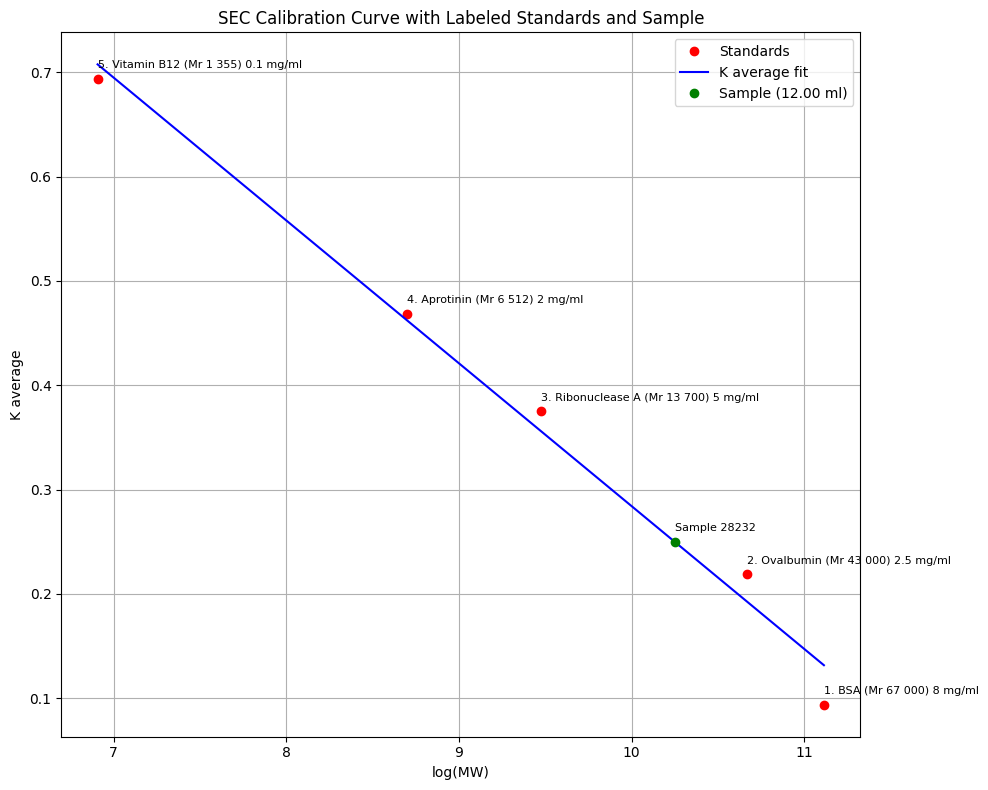


 
 Sample eluting at 12.00 ml has a molecular weight of 28 KDa


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def calculate_kav(elution_volume, void_volume, total_volume):
    """Calculates Kav (distribution coefficient)."""
    return (elution_volume - void_volume) / (total_volume - void_volume)

def linear_fit(x, a, b):
    """Defines a linear function for fitting."""
    return a * x + b


# Calculate Kav for standards
df_standards['K average'] = calculate_kav(df_standards['Elution Volume (ml)'], V0, Vcol)

# Prepare data for fitting
x_standards = np.log(df_standards['MW (Mr)'])
y_standards = df_standards['K average']
mw_standards = df_standards['MW (Mr)'].values  # Get MW values for labels
mw_standards_names = df_standards['Sample'].values

# Perform the fit
alpha_mw, pcov = curve_fit(linear_fit, xdata=x_standards, ydata=y_standards)
slope, intercept = alpha_mw


# Calculate Kav for the sample
kav_sample = calculate_kav(sample_elution_ml, V0, Vcol)

# Calculate log(MW) of the sample using the calibration curve
log_mw_sample = (kav_sample - intercept) / slope

# Calculate MW of the sample
mw_sample = np.exp(log_mw_sample)


# Visualize the data and the fit, including labels
plt.figure(figsize=(10, 8))  # Adjust figure size
plt.plot(x_standards, y_standards, 'ro', label='Standards')
plt.plot(x_standards, linear_fit(x_standards, slope, intercept), 'b-', label='K average fit')

# Plot the sample
plt.plot(log_mw_sample, kav_sample, 'go', label=f'Sample ({sample_elution_ml:.2f} ml)')

# Add labels for standards
for i, (x, y, mw) in enumerate(zip(x_standards, y_standards, mw_standards_names)):
    plt.text(x, y + 0.01, mw, fontsize=8)  # Adjust offset and fontsize as needed

# Add label for sample
plt.text(log_mw_sample, kav_sample + 0.01, 'Sample ' +f'{mw_sample:.0f}', fontsize=8)

plt.xlabel('log(MW)')
plt.ylabel('K average')
plt.title('SEC Calibration Curve with Labeled Standards and Sample')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'\n \n Sample eluting at {sample_elution_ml:.2f} ml has a molecular weight of {mw_sample/1000:.0f} KDa')